### oxford_flowers102 dataseti

In [1]:
import tensorflow as tf

In [2]:
data_name = 'oxford_flowers102'

#### Tensorflow datasetlaridan uc_merged datasetini yuklab olamiz

In [3]:
import tensorflow_datasets as tfds

(train,test,validation), info = tfds.load(
    data_name,
    split=['test','train','validation'],
    data_dir="dataset\\",
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
    batch_size=-1
)

In [4]:
info

tfds.core.DatasetInfo(
    name='oxford_flowers102',
    full_name='oxford_flowers102/2.1.1',
    description="""
    The Oxford Flowers 102 dataset is a consistent of 102 flower categories commonly
    occurring in the United Kingdom. Each class consists of between 40 and 258
    images. The images have large scale, pose and light variations. In addition,
    there are categories that have large variations within the category and several
    very similar categories.
    
    The dataset is divided into a training set, a validation set and a test set. The
    training set and validation set each consist of 10 images per class (totalling
    1020 images each). The test set consists of the remaining 6149 images (minimum
    20 per class).
    
    Note: The dataset by default comes with a test size larger than the train size.
    For more info see this
    [issue](https://github.com/tensorflow/datasets/issues/3022).
    """,
    homepage='https://www.robots.ox.ac.uk/~vgg/data/flowers/102

#### Image va labellarni preprocessingdan o'tkazamiz 

In [5]:
train_images,train_labels = tfds.as_numpy(train)
test_images,test_labels = tfds.as_numpy(test)
validation_images,validation_labels = tfds.as_numpy(validation)

In [6]:
import cv2
import numpy as np

def preprocessing(images,label):
    images_ = []
    
    for i in range(len(images)):
        image = cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB)
        image = cv2.resize(image,(224,224),interpolation = cv2.INTER_AREA)
        image = image/127.5-1.0
        image = image.astype('float16')
        
        images_.append(image)
        
    label = label.astype('uint16')
    images = np.array(images_)
    return images,label

In [7]:
train_images,train_labels = preprocessing(train_images,train_labels)
print(f"Train images shape:{train_images.shape}\nTrain labels shape:{train_labels.shape}")

Train images shape:(6149, 224, 224, 3)
Train labels shape:(6149,)


In [8]:
test_images,test_labels = preprocessing(test_images,test_labels)
print(f"Test images shape:{test_images.shape}\nTest labels shape:{test_labels.shape}")

Test images shape:(1020, 224, 224, 3)
Test labels shape:(1020,)


In [9]:
validation_images,validation_labels = preprocessing(validation_images,validation_labels)
print(f"Validation images shape:{validation_images.shape}\nValidation labels shape:{validation_labels.shape}")

Validation images shape:(1020, 224, 224, 3)
Validation labels shape:(1020,)


In [10]:
train_ds = tf.data.Dataset.from_tensor_slices((train_images,train_labels)).batch(32)

test_ds = tf.data.Dataset.from_tensor_slices((test_images,test_labels)).batch(32)

validation_ds = tf.data.Dataset.from_tensor_slices((validation_images,validation_labels)).batch(32)

### Model o'qitish uchun DenseNet arxitekturasidan foydalanamiz


In [11]:
import tensorflow as tf
from tensorflow.keras.models import Model
import tensorflow.keras.backend as K

In [12]:
class DenseNet121(Model):
    def __init__(self, InputShape, Filters=32):
        super(DenseNet121, self).__init__()
        
        self.InputShape = InputShape
        self.Filters = Filters

        def Convolution_Block(x, Filters, kernel=1, strides=1):
            x = tf.keras.layers.BatchNormalization()(x)
            x = tf.keras.layers.ReLU()(x)
            x = tf.keras.layers.Conv2D(Filters, kernel, strides=strides, padding='same')(x)
            return x

        def Dense_Block(x, repetition):
            for _ in range(repetition):
                y = Convolution_Block(x, 4 * Filters)
                y = Convolution_Block(y, Filters, 3)
                x = tf.keras.layers.Concatenate()([y, x])
            return x

        def Transition_Layer(x):
            x = Convolution_Block(x, K.int_shape(x)[-1] // 2)
            x = tf.keras.layers.AvgPool2D(2, strides=2, padding='same')(x)
            return x

        inputs = tf.keras.layers.Input(InputShape)
        x = tf.keras.layers.Conv2D(64, 7, strides=2, padding='same')(inputs)
        x = tf.keras.layers.MaxPool2D(3, strides=2, padding='same')(x)

        for repetition in [6, 12, 24, 16]:
            d = Dense_Block(x, repetition)
            x = Transition_Layer(d)

        x = tf.keras.layers.GlobalAveragePooling2D()(d)
        output = tf.keras.layers.Dense(102, activation='softmax')(x)

        self.model = Model(inputs, output)

    def call(self, inputs):
        return self.model(inputs)

In [13]:
inputs_shape = 224, 224, 3
model = DenseNet121(inputs_shape)

inputs_tensor = tf.keras.layers.Input(inputs_shape)
output_tensor = model(inputs_tensor)

model = Model(inputs=inputs_tensor, outputs=output_tensor)

In [14]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy()

optimizer = tf.keras.optimizers.Adam()

In [15]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')

In [16]:
@tf.function
def train_step(images, labels):
    with tf.GradientTape() as tape:

        predictions = model(images, training=True)
        loss = loss_object(labels, predictions)
        
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    train_loss(loss)
    train_accuracy(labels, predictions)

In [17]:
@tf.function
def test_step(images, labels):
    
    predictions = model(images, training=False)
    t_loss = loss_object(labels, predictions)

    test_loss(t_loss)
    test_accuracy(labels, predictions)

In [18]:
EPOCHS = 5

loss,val_loss = [],[]
accuracy, val_accuracy = [],[]

for epoch in range(EPOCHS):

    train_loss.reset_states()
    train_accuracy.reset_states()
    
    test_loss.reset_states()
    test_accuracy.reset_states()

    for images, labels in train_ds:
        train_step(images, labels)

    for val_images, val_labels in validation_ds:
        test_step(val_images, val_labels)
    
    loss.append(train_loss.result())
    accuracy.append(train_accuracy.result())
    
    val_loss.append(test_loss.result())
    val_accuracy.append(test_accuracy.result())
    
    print(f"** {epoch + 1}-epoch:\nloss: {train_loss.result()}\tsparse_categorical_accuracy: {train_accuracy.result()}\nval_loss: {test_loss.result()}\tval_sparse_categorical_accuracy:{test_accuracy.result()}")

** 1-epoch:
loss: 3.9972922801971436	sparse_categorical_accuracy: 0.11140022426843643
val_loss: 9.916070938110352	val_sparse_categorical_accuracy:0.01274509821087122
** 2-epoch:
loss: 3.271921157836914	sparse_categorical_accuracy: 0.2008456587791443
val_loss: 4.767903804779053	val_sparse_categorical_accuracy:0.09509804099798203
** 3-epoch:
loss: 2.897749423980713	sparse_categorical_accuracy: 0.2603675425052643
val_loss: 4.941200256347656	val_sparse_categorical_accuracy:0.10784313827753067
** 4-epoch:
loss: 2.5932817459106445	sparse_categorical_accuracy: 0.319076269865036
val_loss: 5.119296550750732	val_sparse_categorical_accuracy:0.14803922176361084
** 5-epoch:
loss: 2.32743763923645	sparse_categorical_accuracy: 0.37664660811424255
val_loss: 4.752178192138672	val_sparse_categorical_accuracy:0.15294118225574493


In [19]:
for test_images,test_labels in test_ds:
    test_step(test_images, test_labels)
    
print(f"test_loss: {test_loss.result()}\ntest_accuracy: {test_accuracy.result()}")

test_loss: 4.85431432723999
test_accuracy: 0.15490196645259857


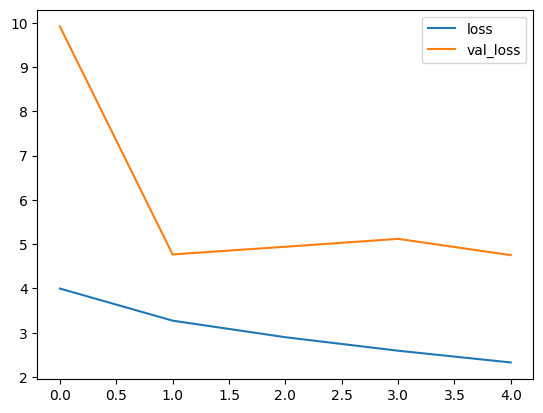

In [20]:
import matplotlib.pyplot as plt
epochs = [i for i in range(EPOCHS)]

plt.plot(epochs, loss, label='loss')
plt.plot(epochs, val_loss, label='val_loss')
plt.legend()
plt.show()

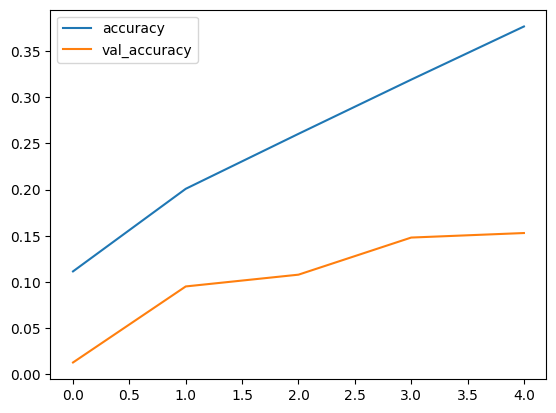

In [21]:
plt.plot(epochs, accuracy, label='accuracy')
plt.plot(epochs, val_accuracy, label='val_accuracy')
plt.legend()
plt.show()

In [22]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 dense_net121 (DenseNet121)  (None, 102)               7147942   
                                                                 
Total params: 7,147,942
Trainable params: 7,066,470
Non-trainable params: 81,472
_________________________________________________________________


In [23]:
model.save('models/DenseNet/model')

INFO:tensorflow:Assets written to: models/DenseNet/model\assets


INFO:tensorflow:Assets written to: models/DenseNet/model\assets
